In [29]:
import matplotlib.pyplot as plt
from pickle_loader import pickle_loader
import datetime as dt
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
import statistics

In [30]:
technical_data = pickle_loader("batch_1/technical_us.pickle")

In [31]:
technical_data['MMM'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2021-09-30 00:00:00-04:00 to 2023-09-29 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          503 non-null    float64
 1   High          503 non-null    float64
 2   Low           503 non-null    float64
 3   Close         503 non-null    float64
 4   Volume        503 non-null    int64  
 5   Dividends     503 non-null    float64
 6   Stock Splits  503 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 31.4 KB


In [32]:
list(technical_data['MMM']['Close'])

[159.88699340820312,
 161.03541564941406,
 160.4520721435547,
 162.12916564941406,
 162.6031036376953,
 162.05624389648438,
 161.28150939941406,
 160.67080688476562,
 159.9872589111328,
 161.4820098876953,
 164.3531036376953,
 165.82965087890625,
 165.629150390625,
 166.16688537597656,
 166.26715087890625,
 165.9937286376953,
 164.79061889648438,
 166.24891662597656,
 166.0301971435547,
 162.45729064941406,
 163.94293212890625,
 162.85829162597656,
 163.6786346435547,
 165.8570098876953,
 166.0939483642578,
 164.61741638183594,
 165.70205688476562,
 165.46505737304688,
 165.27365112304688,
 166.26715087890625,
 164.25283813476562,
 167.39735412597656,
 167.07833862304688,
 167.1330108642578,
 167.10569763183594,
 164.26637268066406,
 164.68905639648438,
 165.0841827392578,
 164.90042114257812,
 163.21888732910156,
 161.28004455566406,
 161.93243408203125,
 156.24462890625,
 156.878662109375,
 156.44677734375,
 158.58773803710938,
 162.82374572753906,
 162.22647094726562,
 161.757843017

### Remove Tickers that don't contain the full dataset 

In [33]:
def tech_clean(dataset):
    clean_dataset = dataset.copy()
    tickers = list(technical_data.keys())
    removed_tickers = []
    
    for ticker in tickers:
        if len(dataset[ticker]) == 0: # Remove tickers that are empty 
            clean_dataset.pop(ticker, None)
            removed_tickers.append(ticker)
        else: # Remove tickers that don't contain the full dataset 
            first_time = dataset[ticker].index.to_pydatetime()[0].strftime('%d-%m-%Y')
            last_time = dataset[ticker].index.to_pydatetime()[-1].strftime('%d-%m-%Y')
            if first_time != '30-09-2021' or last_time != '29-09-2023':
                clean_dataset.pop(ticker, None)
                removed_tickers.append(ticker)
    
    return clean_dataset, removed_tickers 

In [34]:
clean_tech_data, removed_tickers = tech_clean(technical_data)

In [35]:
def get_train_test_subset(dict_technical_data, start_date, end_date):
    """
    This function takes a dictionary of technical data as input and returns a dictionary 
    containing only the subset of technical data used in the train/test set.
    
    Parameters:
    dict_fundamental_data : A dictionary where the key is the stock and the value is a 
    dataframe of the given stocks technical data.
    
    start_date: string in the format 'YYYY-MM-DD' and is start date of the train/test set
    
    end_date: string in the format 'YYYY-MM-DD' and is end date of the train/test set
    
    Returns:
    dict_train_test: A dict where the key is the stock and the value is a df containing 
    only the dates between start_date and end_date
    """
    # Convert the start and end date in pd.Timestamp format
    start_date = pd.Timestamp(start_date + ' 00:00:00-0400', tz='America/New_York')
    end_date = pd.Timestamp(end_date + ' 00:00:00-0400', tz='America/New_York')
    
    dict_train_test = {}
    
    for stock, data in dict_technical_data.items():
        stock_df = data[(data.index >= start_date) & (data.index <= end_date)]
        dict_train_test[stock] = stock_df
    
    return dict_train_test

In [36]:
dict_train_test = get_train_test_subset(clean_tech_data, '2021-09-30', '2023-06-30')

## Get Grad

In [37]:
class get_gradients_variance:


    
    def __init__(self,  chunk_end_dates, data): 
        self.chunk_end_dates = chunk_end_dates.tz_localize('America/New_York')
        self.data = data

    def get_gradient(self, time_periods = (1,3,6,12)):
        self.time_periods = time_periods
        self.chunk_dates = self.n_chunks(time_periods)
        # print(self.chunk_dates)
        self.chunked_data = self.split_data()
        self.gradients = self.get_gradients()

        return self.gradients  

    def get_gradients(self):
        # get the gradients for a given chunk of data
        chunked_data = self.chunked_data
        end_dates = self.chunk_end_dates
        gradients = {}

        for time_period, chunks in chunked_data.items():
            time_period_grad = []
            
            for i, chunk in enumerate(chunks):
                close_prices = list(chunk['Close'])
                grad_chunk = self.rate_of_return(close_prices)
                time_period_grad.append((end_dates[i], grad_chunk))
                
            gradients[time_period] = time_period_grad

        return gradients
    
    def get_variance(self):
        chunked_data = self.chunked_data
        end_dates = self.chunk_end_dates
        data_12m = chunked_data[12]
        variances = []
        
        for i, chunk in enumerate(data_12m):
            by_month = self.split_by_month(chunk)
            by_month_close = [list(month_data['Close']) for month_data in by_month]
            monthly_ror = [self.rate_of_return(month_close) for month_close in by_month_close]
            var = statistics.variance(monthly_ror)
            variances.append((end_dates[i], var))
        
        return variances 
                
            
    def rate_of_return(self, lst_of_prices):
        return (lst_of_prices[-1] - lst_of_prices[0]) / lst_of_prices[0]
       
    def split_by_month(self, df):
        
        dfs_by_month = [group for month, group in df.groupby(df.index.to_period('M'))]
        
        return dfs_by_month
    
    def split_data(self):
        # splits data_set based of chunk dates
        chunk_dates = self.chunk_dates
        data = self.data
        chunked_data = {}

        for n_months, dates in chunk_dates.items():
            chunked_data[n_months] = [data[(data.index >= start_date) & (data.index <= end_date)] for start_date, end_date in dates]

        return chunked_data
 
    def n_chunks(self, chunk_sizes):
        # get the start and end date foe each chunk 
        chunk_end_dates = self.chunk_end_dates 
        chunk_sizes = self.time_periods
        n_chunk_dates = {}

        for chunk in chunk_sizes:
            current_chunks = []
            
            for date in chunk_end_dates:
                current_chunks.append((date - pd.DateOffset(months=chunk), date))

            n_chunk_dates[chunk] = current_chunks
        #print(n_chunk_dates)

        return n_chunk_dates

In [38]:
fundamental_data = pickle_loader("final_fundamental_dict.pickle")
chunk_end_dates = fundamental_data['AOS'].columns
grad_obj = get_gradients_variance(chunk_end_dates=chunk_end_dates, data=dict_train_test['AOS'])
grads = grad_obj.get_gradient()
variances= grad_obj.get_variance()

/var/folders/zg/dl66jjcj00lc_vzv2wkjyln00000gn/T/ipykernel_82557/3438247170.py:57: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  dfs_by_month = [group for month, group in df.groupby(df.index.to_period('M'))]


In [39]:
variances

[(Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'),
  0.00982373195480827),
 (Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'),
  0.009895077747439777),
 (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
  0.008094396681464108),
 (Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'),
  0.010711664866020619)]

In [40]:
grads

{1: [(Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'),
   0.09131799171590796),
  (Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'),
   0.0536339243024572),
  (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
   -0.057622733984634904),
  (Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'),
   -0.15424785949388609)],
 3: [(Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'),
   0.07665546371047938),
  (Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'),
   0.1794875665049432),
  (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
   0.18511291890374734),
  (Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'),
   -0.1074299226227769)],
 6: [(Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'),
   0.2835441763914544),
  (Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'),
   0.43885218527951414),
  (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
   0.0577963297266645),


In [41]:
list(dict_train_test['MMM']['Close'])

[159.88699340820312,
 161.03541564941406,
 160.4520721435547,
 162.12916564941406,
 162.6031036376953,
 162.05624389648438,
 161.28150939941406,
 160.67080688476562,
 159.9872589111328,
 161.4820098876953,
 164.3531036376953,
 165.82965087890625,
 165.629150390625,
 166.16688537597656,
 166.26715087890625,
 165.9937286376953,
 164.79061889648438,
 166.24891662597656,
 166.0301971435547,
 162.45729064941406,
 163.94293212890625,
 162.85829162597656,
 163.6786346435547,
 165.8570098876953,
 166.0939483642578,
 164.61741638183594,
 165.70205688476562,
 165.46505737304688,
 165.27365112304688,
 166.26715087890625,
 164.25283813476562,
 167.39735412597656,
 167.07833862304688,
 167.1330108642578,
 167.10569763183594,
 164.26637268066406,
 164.68905639648438,
 165.0841827392578,
 164.90042114257812,
 163.21888732910156,
 161.28004455566406,
 161.93243408203125,
 156.24462890625,
 156.878662109375,
 156.44677734375,
 158.58773803710938,
 162.82374572753906,
 162.22647094726562,
 161.757843017

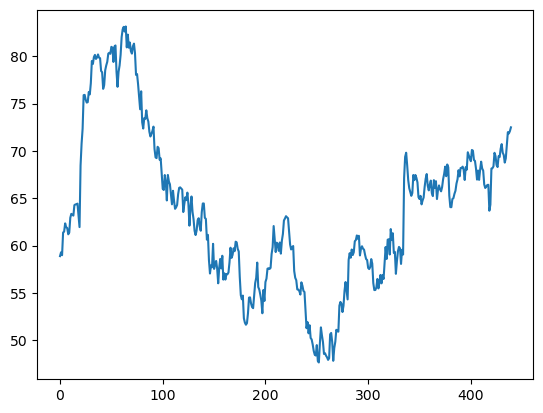

In [42]:
import matplotlib.pyplot as plt

plt.plot(list(dict_train_test['AOS']['Close']))

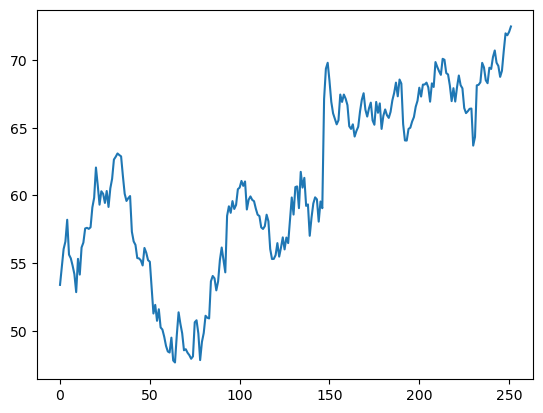

In [43]:
plt.plot(list(grad_obj.chunked_data[12][0]['Close']))

In [44]:
grad_obj.chunk_dates

{1: [(Timestamp('2023-05-30 00:00:00-0400', tz='America/New_York'),
   Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York')),
  (Timestamp('2023-02-28 00:00:00-0500', tz='America/New_York'),
   Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York')),
  (Timestamp('2022-11-30 00:00:00-0500', tz='America/New_York'),
   Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York')),
  (Timestamp('2022-08-30 00:00:00-0400', tz='America/New_York'),
   Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'))],
 3: [(Timestamp('2023-03-30 00:00:00-0400', tz='America/New_York'),
   Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York')),
  (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
   Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York')),
  (Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'),
   Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York')),
  (Timestamp('2022-06-30 00:00:00-0400', tz='America/New_York'),
   Timestam

In [45]:
def get_data_all_stock(stock_dict, chunk_end_dates):
    grad_var_dict = {}
    
    for stock in stock_dict.keys():
        grad_object = get_gradients_variance(chunk_end_dates=chunk_end_dates, data=stock_dict[stock])
        grad_var_dict[stock] = (grad_object.get_gradient(), grad_object.get_variance())
        del grad_object

    return grad_var_dict

fundamental_data = pickle_loader("final_fundamental_dict.pickle")
chunk_end_dates = fundamental_data['MMM'].columns
grad_var_dict = get_data_all_stock(dict_train_test, chunk_end_dates)

/var/folders/zg/dl66jjcj00lc_vzv2wkjyln00000gn/T/ipykernel_82557/3438247170.py:57: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  dfs_by_month = [group for month, group in df.groupby(df.index.to_period('M'))]


In [46]:
grad_var_dict.keys()

dict_keys(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP', 'AAP', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BBWI', 'BAX', 'BDX', 'WRB', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BG', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC', 'CNP', 'CDAY', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'D

In [47]:
grad_var_dict['AOS'][0][6]

[(Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'),
  0.2835441763914544),
 (Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'),
  0.43885218527951414),
 (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
  0.0577963297266645),
 (Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'),
  -0.2600151630094605)]

In [49]:
grad_var_dict['AOS'][1]

[(Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'),
  0.00982373195480827),
 (Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'),
  0.009895077747439777),
 (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
  0.008094396681464108),
 (Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'),
  0.010711664866020619)]

In [51]:
grad_var_dict['MMM'][0][6]

[(Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'),
  -0.1414542701549192),
 (Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'),
  -0.024898154124873714),
 (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
  -0.05286107656274476),
 (Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'),
  -0.25535131991857174)]

In [50]:
grad_var_dict['MMM'][1]

[(Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'),
  0.00647058089715991),
 (Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'),
  0.00620581668905123),
 (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
  0.006866487355166597),
 (Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'),
  0.005613086869756687)]

### Create Final Dataset

In [90]:
data = grad_dict['AOS']

# Initialize an empty dictionary for the output
restructured_data = {}

# Iterate through each period and the associated list of tuples
for period, values in data.items():
    for timestamp, gradient in values:
        # If the timestamp is not already a key, initialize an empty list for it
        if timestamp not in restructured_data:
            restructured_data[timestamp] = []
        # Append the tuple of period and gradient to the list for this timestamp
        restructured_data[timestamp].append((period, gradient))

# Print or return the restructured dictionary
print(restructured_data)

{Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'): [(1, 0.08733056577491818), (3, 0.07382588498673215), (6, 0.24833693109412228), (12, 0.3034516877725749)], Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'): [(1, 0.05223318885392355), (3, 0.16470620825130192), (6, 0.35988420120608317), (12, 0.09891203355323497)], Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'): [(1, -0.059332175054584976), (3, 0.16943098665730916), (6, 0.05617303218180153), (12, -0.3820053810686794)], Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'): [(1, -0.1671382154828119), (3, -0.11352807899367859), (6, -0.29887060792918185), (12, -0.2108584180782828)]}


In [81]:
class get_final_dataset():

    def __init__(self, grad_dict):
        self.grad_dict = grad_dict

    def get_dataset(self):
        grad_dict = self.grad_dict
        self.re_grad_dict = {k:self.restructure_grad_data(v[0]) for k,v in grad_dict.items()}
        self.final_dict = self.add_var()
        self.dict_dfs = self.create_dfs()
        
        return self.dict_dfs
        

    def restructure_grad_data(self, data):
        grad_dict = self.grad_dict
        # Initialize an empty dictionary for the output
        restructured_data = {}

        # Iterate through each period and the associated list of tuples
        for period, values in data.items():
            for timestamp, gradient in values:
        # If the timestamp is not already a key, initialize an empty list for it
                if timestamp not in restructured_data:
                    restructured_data[timestamp] = []
                # Append the tuple of period and gradient to the list for this timestamp
                restructured_data[timestamp].append((period, gradient))
        return restructured_data
    
    def add_var(self):
        re_grad_dict = self.re_grad_dict
        grad_dict = self.grad_dict
        final_dict = {}
        
        for stock, grads in re_grad_dict.items():
            grads_vars = {}
            variances = grad_dict[stock][1]
            
            for variance in variances:
                timestamp = variance[0]
                timestamp_grad = grads[timestamp]
                timestamp_grad.append(('var', variance[1]))
                grads_vars[timestamp] = timestamp_grad
            
            final_dict[stock] = grads_vars
        
        return final_dict

    def create_dfs(self):
        final_dict = self.final_dict
        index = list(final_dict.keys())
        timestamps = list(final_dict[index[0]].keys())
        index = list(final_dict.keys())
        columns = [tupple[0] for tupple in final_dict[index[0]][timestamps[0]]]
        
        dict_df_arrays = {timestamp:np.zeros((len(index), 5)) for timestamp in timestamps}

        for i ,stock in enumerate(index):
            for timestamp in timestamps:
                current_array = dict_df_arrays[timestamp]
                current_array[i] = [tupple[1] for tupple in final_dict[stock][timestamp]]
        
        dict_dfs = {}
        
        for timestamp, arr in dict_df_arrays.items():
            df_timestamp = pd.DataFrame(data = arr,  
                  index = index,  
                  columns = columns)
            dict_dfs[timestamp] = df_timestamp
        
        return dict_dfs
    



In [82]:
df_obj = get_final_dataset(grad_var_dict)
dict_dfs = df_obj.get_dataset()

In [90]:
print(list(dict_dfs.keys())[1])
dict_dfs[list(dict_dfs.keys())[1]]

2023-03-31 00:00:00-04:00


,1,3,6,12,var
MMM,-0.024411,-0.130385,-0.024898,-0.261455,0.006206
AOS,0.053634,0.179488,0.438852,0.104058,0.009895
ABT,-0.004522,-0.071742,0.056205,-0.129251,0.002458
ABBV,0.035543,-0.009207,0.210953,0.020520,0.003369
ACN,0.076294,0.061863,0.120308,-0.139632,0.006419
...,...,...,...,...,...
YUM,0.038691,0.045116,0.253490,0.135691,0.003239
ZBRA,0.059117,0.222137,0.213694,-0.231327,0.016786
ZBH,0.045020,0.017022,0.240479,0.018577,0.002783
ZION,-0.408732,-0.377537,-0.402076,-0.529642,0.015522


In [92]:
with open("grad_var_df.pickle", 'wb') as f:
        pickle.dump(dict_dfs, f)